In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from keras.models import Model
from keras.layers import Dense, Input, add, BatchNormalization, concatenate, Embedding, Flatten 
from tensorflow.keras.optimizers import Nadam
from keras.layers.core import Dropout, Activation
from keras.initializers import RandomNormal, Ones

import tensorflow as tf

import seaborn as sns

import random
from numpy import array
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def predict_dist(X, model, num_samples):
    preds = [model[0](X, training=True) for _ in range(num_samples)]
    return np.hstack(preds)

def predict_point(X, model, num_samples):
    pred_dist = predict_dist(X, model, num_samples)
    return pred_dist.mean(axis=1), pred_dist

In [3]:
# Function PD: Calculate Poisson Deviance
def PD_function(pred, obs):
    PD = 200*( sum(pred) - sum(obs) + sum( np.log( (obs/pred)**(obs) ) ) )
    return PD/len(pred)
    
# evaluate a single mlp model
def evaluate_model(trainX, trainy, train_expo, trainbrand, trainregion
                  ):
    
    first_input = Input(shape=(7))
    
    brand_input = Input(shape=(1))
    region_input = Input(shape=(1))    
    
    
    Embedding_brand = Flatten()(Embedding(input_dim = 11, output_dim = 2)(brand_input))
    Embedding_region = Flatten()(Embedding(input_dim = 22, output_dim = 2)(region_input))
    
    
    merge_one_ = tf.keras.layers.Concatenate()([Embedding_brand, Embedding_region, first_input])
    

    first_dense_00 = Dense(50)(merge_one_)
    act_dense_00 = Activation("tanh")(first_dense_00)
    act_dense_00 = BatchNormalization()(act_dense_00)
    Dropout_dense_00 = Dropout(0.3)(act_dense_00)

    first_dense_0 = Dense(25)(Dropout_dense_00)
    act_dense_0 = Activation("tanh")(first_dense_0)
    act_dense_0 = BatchNormalization()(act_dense_0)
    Dropout_dense_0 = Dropout(0.2)(act_dense_0)

    first_dense_1 = Dense(15)(Dropout_dense_0)
    act_dense_1 = Activation("tanh")(first_dense_1)
    act_dense_1 = BatchNormalization()(act_dense_1)
    Dropout_dense_1 = Dropout(0.1)(act_dense_1)

    first_dense_2 = Dense(8)(Dropout_dense_1)
    act_dense_2 = Activation("tanh")(first_dense_2)
    act_dense_2 = BatchNormalization()(act_dense_2)
    Dropout_dense_2 = Dropout(0.1)(act_dense_2)

    first_dense_3 = Dense(1, 
                          #bias_initializer=tf.keras.initializers.Constant(value=-2.29881790925729), 
                          #kernel_initializer=tf.keras.initializers.Zeros()
                         )(Dropout_dense_2)
    act_dense_3 = Activation('linear')(first_dense_3)

    
    second_input = Input(shape=(1, ))

    second_dense_1 = Dense(1, 
                           bias_initializer=tf.keras.initializers.Constant(value=0), 
                           kernel_initializer=tf.keras.initializers.Ones(), 
                           trainable=False)(add([act_dense_3, second_input])) 
    
    outputt = Activation('exponential')(second_dense_1) 

    model_ = Model(inputs=[first_input, second_input, brand_input, region_input], outputs=outputt)

    model_.compile(optimizer=Nadam(), loss='poisson')
    
    model_.fit([trainX, train_expo, trainbrand, trainregion], trainy, 
               epochs=450, verbose=0, batch_size=10000)

    #preds = model_.predict([testX, test_expo, testbrand, testregion]).flatten()  

    return model_, 0

, 81, 37 ,71, 28, 70, 54, 59, 17, 79

, 54, 42, 88, 29

In [4]:
df_poisson_10 = pd.DataFrame()
df_poisson_20 = pd.DataFrame()
df_poisson_30 = pd.DataFrame()
df_poisson_40 = pd.DataFrame()
df_poisson = pd.DataFrame()

table_name = ["deviance_train", "deviance_test", "diff_train", "diff_test"]

for p in [62]:
    
    print(p)
    
    data_learn = pd.read_csv(r'C:\Users\KRASNIQ\Documents\These_1.1\data\data_learn_'+str(62)+'.csv')
    data_test = pd.read_csv(r'C:\Users\KRASNIQ\Documents\These_1.1\data\data_test_'+str(62)+'.csv')
    
    nex_data = pd.concat([data_learn, data_test])
    
    data_learn_, data_test_ = train_test_split(nex_data, stratify=nex_data['ClaimNb'], test_size=0.1, random_state=p)
    
    data_learn_['Exposure'] = data_learn_['Exposure'].clip(upper=1)
    data_test_['Exposure'] = data_test_['Exposure'].clip(upper=1)
    
    data_learn_['Area'] = data_learn_['Area'].map({"A": 1, "B": 2,"C": 3,"D": 4,"E": 5,"F": 6,})
    data_test_['Area'] = data_test_['Area'].map({"A": 1, "B": 2,"C": 3,"D": 4,"E": 5,"F": 6,})
    
    data_learn_ = data_learn_.drop(["Area_class_1","Area_class_2","Area_class_3","Area_class_4",'ClaimAmount', 'DrivAge', 'BonusMalus',
                                    "VehBrand_class_1", "VehBrand_class_2", "VehBrand_class_3",
                                    'Density',"Region_class_1", "Region_class_2", "Region_class_3", "Region_class_4" , 
                                    'VehAge', 'VehGas', "VehGas_class_2"], axis=1)

    data_test_ = data_test_.drop(["Area_class_1","Area_class_2","Area_class_3","Area_class_4",'ClaimAmount', 'DrivAge', 'BonusMalus',
                                  "VehBrand_class_1", "VehBrand_class_2", "VehBrand_class_3",
                                  'Density',"Region_class_1", "Region_class_2", "Region_class_3", "Region_class_4" , 
                                  'VehAge', 'VehGas', "VehGas_class_2"], axis=1)
    
    # train test split 
    X_train__, X_valid__ = train_test_split(data_learn_, stratify=data_learn_['ClaimNb'], test_size=0.1, random_state=p)
    
    #################### label encoding
    
    le_region = preprocessing.LabelEncoder()
    le_region.fit(X_train__['Region'])

    le_brand = preprocessing.LabelEncoder()
    le_brand.fit(X_train__['VehBrand'])
    
    y_train = np.array(X_train__.filter(['ClaimNb']))
    log_exp_train= np.array(np.log(X_train__.filter(['Exposure'])))
    region_train = np.array(le_region.transform(X_train__['Region']))
    brand_train = np.array(le_brand.transform(X_train__['VehBrand']))
    x_train = X_train__.drop(columns=['ClaimNb', 'Exposure', 'VehBrand', 'Region'])

    y_valid = np.array(X_valid__.filter(['ClaimNb']))
    log_exp_valid= np.array(np.log(X_valid__.filter(['Exposure'])))
    region_valid = np.array(le_region.transform(X_valid__['Region']))
    brand_valid = np.array(le_brand.transform(X_valid__['VehBrand']))
    x_valid = X_valid__.drop(columns=['ClaimNb', 'Exposure', 'VehBrand', 'Region'])
    
    #valid
    y_test = np.array(data_test_.filter(['ClaimNb']))
    log_exp_test = np.array(np.log(data_test_.filter(['Exposure'])))
    region_test = np.array(le_region.transform(data_test_['Region']))
    brand_test = np.array(le_brand.transform(data_test_['VehBrand']))
    x_test = data_test_.drop(columns=['ClaimNb', 'Exposure', 'VehBrand', 'Region'])
    
    #feature eng
    cs = MinMaxScaler()
    X_train = np.array(2*((x_train - x_train.min())/(x_train.max()-x_train.min())) - 1)
    X_valid = np.array(2*((x_valid - x_train.min())/(x_train.max()-x_train.min())) - 1)
    X_test = np.array(2*((x_test - x_train.min())/(x_train.max()-x_train.min())) - 1)
    
    
    print(X_train.shape)
    model = evaluate_model(X_train, y_train, log_exp_train, brand_train, region_train)
    
    
    ############################### strategie 1 ##########################################################
    
    print('strategie Drop Out')
    
    print('10')
    predictions_test_10, pred_dist_test_10 = predict_point([X_test, log_exp_test, brand_test, region_test], model, 10)
    predictions_train_10, pred_dist_train_10 = predict_point([X_train, log_exp_train, brand_train, region_train], model, 10)

    #deviance
    table_modal= [np.round(PD_function(predictions_train_10, y_train.flatten()),6),
                  np.round(PD_function(predictions_test_10, y_test.flatten()),6),
                  (sum(predictions_train_10) - sum(y_train.flatten()))/sum(y_train.flatten())*100,
                  (sum(predictions_test_10) -sum(y_test.flatten()))/sum(y_test.flatten())*100]

    cnt = dict()
    k=0
    for word in table_name:
        cnt[word] = table_modal[k]
        k = k+1
    df_poisson_10 = df_poisson_10.append(cnt, ignore_index=True)
    

    print('20')    
    predictions_test_20, pred_dist_test_20 = predict_point([X_test, log_exp_test, brand_test, region_test], model, 20)
    predictions_train_20, pred_dist_train_20 = predict_point([X_train, log_exp_train, brand_train, region_train], model, 20)

    #deviance
    table_modal= [np.round(PD_function(predictions_train_20, y_train.flatten()),6),
                  np.round(PD_function(predictions_test_20, y_test.flatten()),6),
                  (sum(predictions_train_20) - sum(y_train.flatten()))/sum(y_train.flatten())*100,
                  (sum(predictions_test_20) -sum(y_test.flatten()))/sum(y_test.flatten())*100]

    cnt = dict()
    k=0
    for word in table_name:
        cnt[word] = table_modal[k]
        k = k+1
    df_poisson_20 = df_poisson_20.append(cnt, ignore_index=True)
    
    
    
    

    print('30')
    predictions_test_30, pred_dist_test_30 = predict_point([X_test, log_exp_test, brand_test, region_test], model, 50)
    predictions_train_30, pred_dist_train_30 = predict_point([X_train, log_exp_train, brand_train, region_train], model, 50)

    #deviance
    table_modal= [np.round(PD_function(predictions_train_30, y_train.flatten()),6),
                  np.round(PD_function(predictions_test_30, y_test.flatten()),6),
                  (sum(predictions_train_30) - sum(y_train.flatten()))/sum(y_train.flatten())*100,
                  (sum(predictions_test_30) -sum(y_test.flatten()))/sum(y_test.flatten())*100]

    cnt = dict()
    k=0
    for word in table_name:
        cnt[word] = table_modal[k]
        k = k+1
    df_poisson_30 = df_poisson_30.append(cnt, ignore_index=True)

    
    
    print('40')
    predictions_test_40, pred_dist_test_40 = predict_point([X_test, log_exp_test, brand_test, region_test], model, 50)
    predictions_train_40, pred_dist_train_40 = predict_point([X_train, log_exp_train, brand_train, region_train], model, 50)

    #deviance
    table_modal= [np.round(PD_function(predictions_train_40, y_train.flatten()),6),
                  np.round(PD_function(predictions_test_40, y_test.flatten()),6),
                  (sum(predictions_train_40) - sum(y_train.flatten()))/sum(y_train.flatten())*100,
                  (sum(predictions_test_40) -sum(y_test.flatten()))/sum(y_test.flatten())*100]

    cnt = dict()
    k=0
    for word in table_name:
        cnt[word] = table_modal[k]
        k = k+1
    df_poisson_40 = df_poisson_40.append(cnt, ignore_index=True)

62
(549171, 7)
Epoch 1/450
55/55 [==============================] - 4s 30ms/step - loss: 0.2411
Epoch 2/450
55/55 [==============================] - 2s 43ms/step - loss: 0.2199
Epoch 3/450
55/55 [==============================] - 2s 44ms/step - loss: 0.2186
Epoch 4/450
55/55 [==============================] - 2s 44ms/step - loss: 0.2175
Epoch 5/450
55/55 [==============================] - 2s 40ms/step - loss: 0.2161
Epoch 6/450
55/55 [==============================] - 2s 40ms/step - loss: 0.2158
Epoch 7/450
55/55 [==============================] - 2s 36ms/step - loss: 0.2151
Epoch 8/450
55/55 [==============================] - 2s 40ms/step - loss: 0.2143
Epoch 9/450
55/55 [==============================] - 2s 44ms/step - loss: 0.2138
Epoch 10/450
55/55 [==============================] - 2s 40ms/step - loss: 0.2134
Epoch 11/450
55/55 [==============================] - 2s 39ms/step - loss: 0.2130
Epoch 12/450
55/55 [==============================] - 2s 38ms/step - loss: 0.2125
Epoch 13/4

55/55 [==============================] - 2s 30ms/step - loss: 0.2051
Epoch 101/450
55/55 [==============================] - 2s 30ms/step - loss: 0.2051
Epoch 102/450
55/55 [==============================] - 2s 31ms/step - loss: 0.2051
Epoch 103/450
55/55 [==============================] - 2s 30ms/step - loss: 0.2051
Epoch 104/450
55/55 [==============================] - 2s 31ms/step - loss: 0.2052
Epoch 105/450
55/55 [==============================] - 2s 30ms/step - loss: 0.2051
Epoch 106/450
55/55 [==============================] - 2s 30ms/step - loss: 0.2050
Epoch 107/450
55/55 [==============================] - 2s 32ms/step - loss: 0.2050
Epoch 108/450
55/55 [==============================] - 2s 34ms/step - loss: 0.2050
Epoch 109/450
55/55 [==============================] - 2s 32ms/step - loss: 0.2049
Epoch 110/450
55/55 [==============================] - 2s 34ms/step - loss: 0.2051
Epoch 111/450
55/55 [==============================] - 2s 31ms/step - loss: 0.2050
Epoch 112/450
55/5

55/55 [==============================] - 1s 27ms/step - loss: 0.2041
Epoch 199/450
55/55 [==============================] - 1s 27ms/step - loss: 0.2040
Epoch 200/450
55/55 [==============================] - 1s 27ms/step - loss: 0.2040
Epoch 201/450
55/55 [==============================] - 1s 26ms/step - loss: 0.2040
Epoch 202/450
55/55 [==============================] - 2s 28ms/step - loss: 0.2040
Epoch 203/450
55/55 [==============================] - 1s 27ms/step - loss: 0.2040
Epoch 204/450
55/55 [==============================] - 1s 27ms/step - loss: 0.2040
Epoch 205/450
55/55 [==============================] - 1s 27ms/step - loss: 0.2040
Epoch 206/450
55/55 [==============================] - 2s 28ms/step - loss: 0.2041
Epoch 207/450
55/55 [==============================] - 1s 27ms/step - loss: 0.2040
Epoch 208/450
55/55 [==============================] - 1s 27ms/step - loss: 0.2040
Epoch 209/450
55/55 [==============================] - 2s 28ms/step - loss: 0.2040
Epoch 210/450
55/5

55/55 [==============================] - 2s 31ms/step - loss: 0.2037
Epoch 297/450
55/55 [==============================] - 2s 30ms/step - loss: 0.2038
Epoch 298/450
55/55 [==============================] - 2s 29ms/step - loss: 0.2038
Epoch 299/450
55/55 [==============================] - 2s 30ms/step - loss: 0.2038
Epoch 300/450
55/55 [==============================] - 2s 30ms/step - loss: 0.2038
Epoch 301/450
55/55 [==============================] - 2s 30ms/step - loss: 0.2039
Epoch 302/450
55/55 [==============================] - 2s 32ms/step - loss: 0.2037
Epoch 303/450
55/55 [==============================] - 2s 30ms/step - loss: 0.2037
Epoch 304/450
55/55 [==============================] - 2s 30ms/step - loss: 0.2038
Epoch 305/450
55/55 [==============================] - 2s 31ms/step - loss: 0.2037
Epoch 306/450
55/55 [==============================] - 2s 30ms/step - loss: 0.2037
Epoch 307/450
55/55 [==============================] - 2s 30ms/step - loss: 0.2036
Epoch 308/450
55/5

55/55 [==============================] - 2s 32ms/step - loss: 0.2035
Epoch 395/450
55/55 [==============================] - 2s 33ms/step - loss: 0.2038
Epoch 396/450
55/55 [==============================] - 2s 38ms/step - loss: 0.2035
Epoch 397/450
55/55 [==============================] - 2s 39ms/step - loss: 0.2036
Epoch 398/450
55/55 [==============================] - 2s 36ms/step - loss: 0.2036
Epoch 399/450
55/55 [==============================] - 2s 37ms/step - loss: 0.2036
Epoch 400/450
55/55 [==============================] - 2s 34ms/step - loss: 0.2036
Epoch 401/450
55/55 [==============================] - 2s 33ms/step - loss: 0.2036
Epoch 402/450
55/55 [==============================] - 2s 32ms/step - loss: 0.2036
Epoch 403/450
55/55 [==============================] - 2s 32ms/step - loss: 0.2035
Epoch 404/450
55/55 [==============================] - 2s 34ms/step - loss: 0.2036
Epoch 405/450
55/55 [==============================] - 2s 38ms/step - loss: 0.2036
Epoch 406/450
55/5

C:\Users\KRASNIQ\AppData\Local\Temp\ipykernel_25224\1489888976.py:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_poisson_10 = df_poisson_10.append(cnt, ignore_index=True)


20


C:\Users\KRASNIQ\AppData\Local\Temp\ipykernel_25224\1489888976.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_poisson_20 = df_poisson_20.append(cnt, ignore_index=True)


30


C:\Users\KRASNIQ\AppData\Local\Temp\ipykernel_25224\1489888976.py:135: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_poisson_30 = df_poisson_30.append(cnt, ignore_index=True)


40


C:\Users\KRASNIQ\AppData\Local\Temp\ipykernel_25224\1489888976.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_poisson_40 = df_poisson_40.append(cnt, ignore_index=True)


In [5]:
df_poisson_10

,deviance_train,deviance_test,diff_train,diff_test
0,30.696499,30.744728,-0.164236,-0.445334


In [6]:
df_poisson_10["deviance_train"].mean(), df_poisson_10["deviance_test"].mean()

(30.696499, 30.744728)

In [7]:
df_poisson_10["deviance_train"].std(), df_poisson_10["deviance_test"].std()

(nan, nan)

ensemble 0.06928927
target [0.]


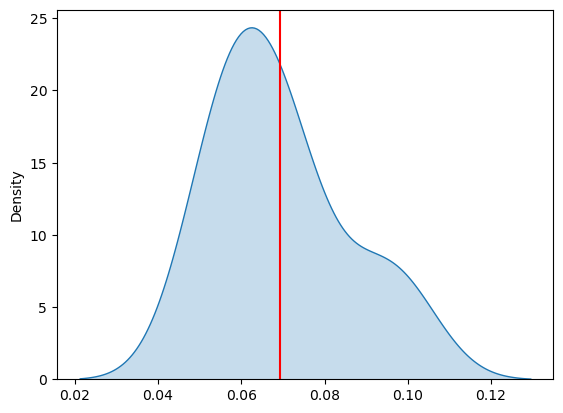

In [8]:
print("ensemble", predictions_test_10[35])
print("target", y_test[35])
sns.kdeplot(pred_dist_test_10[35], shade=True)
plt.axvline(predictions_test_10[35], color='red')
plt.show()

In [9]:
df_poisson_20

,deviance_train,deviance_test,diff_train,diff_test
0,30.685218,30.711734,-0.144059,-0.416859


In [10]:
df_poisson_20["deviance_train"].mean(), df_poisson_20["deviance_test"].mean()

(30.685218, 30.711734)

In [11]:
df_poisson_20["deviance_train"].std(), df_poisson_20["deviance_test"].std()

(nan, nan)

ensemble 0.0693035
target [0.]


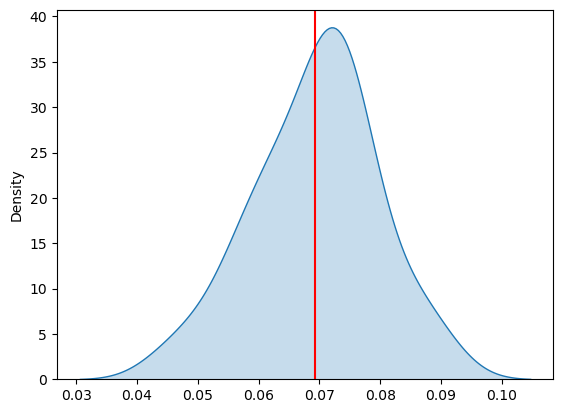

In [12]:
print("ensemble", predictions_test_20[35])
print("target", y_test[35])
sns.kdeplot(pred_dist_test_20[35], shade=True)
plt.axvline(predictions_test_20[35], color='red')
plt.show()

In [13]:
df_poisson_30

,deviance_train,deviance_test,diff_train,diff_test
0,30.679774,30.706937,-0.152301,-0.45584


In [14]:
df_poisson_30["deviance_train"].mean(), df_poisson_30["deviance_test"].mean()

(30.679774, 30.706937)

In [15]:
df_poisson_30["deviance_train"].std(), df_poisson_30["deviance_test"].std()

(nan, nan)

ensemble 0.066891044
target [0.]


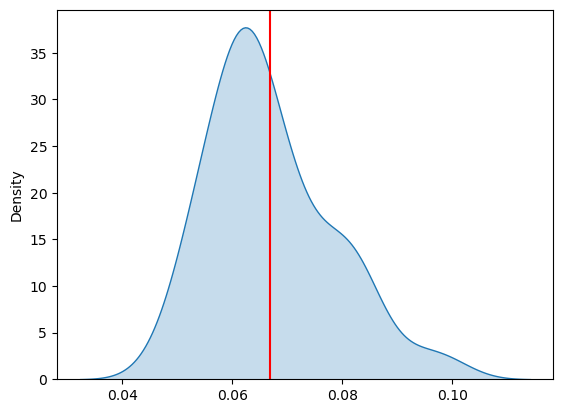

In [16]:
print("ensemble", predictions_test_30[35])
print("target", y_test[35])
sns.kdeplot(pred_dist_test_30[35], shade=True)
plt.axvline(predictions_test_30[35], color='red')
plt.show()

In [17]:
df_poisson_40

,deviance_train,deviance_test,diff_train,diff_test
0,30.682957,30.70231,-0.149691,-0.428641


In [18]:
df_poisson_40["deviance_train"].mean(), df_poisson_40["deviance_test"].mean()

(30.682957, 30.70231)

In [19]:
df_poisson_40["deviance_train"].std(), df_poisson_40["deviance_test"].std()

(nan, nan)

ensemble 0.07017315
target [0.]


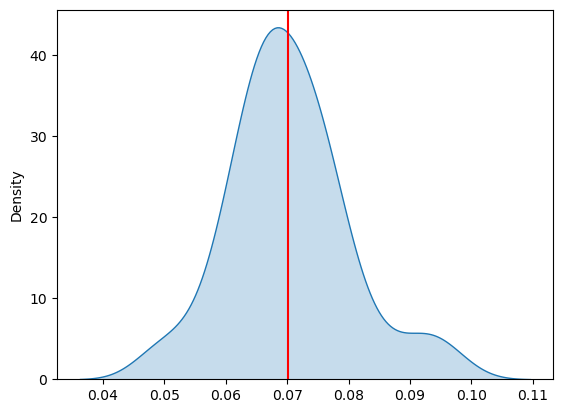

In [20]:
print("ensemble", predictions_test_40[35])
print("target", y_test[35])
sns.kdeplot(pred_dist_test_40[35], shade=True)
plt.axvline(predictions_test_40[35], color='red')
plt.show()